In [4]:
import io

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["TORCH_HOME"] = f"{ROOT_PATH}/huggingface_cache/torch"

import requests
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

# step 1: Setup constant
device = "cuda"
dtype = torch.float16

# step 2: Load Processor and Model
processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True)
model.to(device)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- processing_chexagent.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- configuration_chexagent.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- modeling_chexagent.py


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

CheXagentForConditionalGeneration(
  (vision_model): CheXagentVisionModel(
    (embeddings): CheXagentVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): CheXagentEncoder(
      (layers): ModuleList(
        (0-39): 40 x CheXagentEncoderLayer(
          (self_attn): CheXagentAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): CheXagentMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (

In [65]:

# step 3: Fetch the images
image_path = "/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med/visualize/images/example2.jpg"
images = [Image.open(image_path).convert("RGB")]

# step 4: Generate the Findings section
# prompt = "What is the organ in this image"
prompt = "What is the abnormity on the lungs?"
inputs = processor(images=images, text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(device=device, dtype=dtype)
output = model.generate(**inputs, generation_config=generation_config, output_attentions=True, return_dict_in_generate=True)
response = processor.tokenizer.decode(output['sequences'][0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [66]:
response, len(output['attentions'][0])

('Pulmonary edema', 32)

In [52]:
output['attentions'][0][1].size()

torch.Size([5, 32, 148, 148])

In [53]:
# inputs

In [51]:
inputs['input_ids'].size()

torch.Size([1, 20])

In [56]:
len(output['attentions'])

7

In [59]:
img_token_idx = 0
len_out_tokens = len(output['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = output['attentions'][i]
    # token = processor.tokenizer.decode(output["sequences"][0][i])
    # print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+128]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    # attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+128:-2]
    # text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_after_image.size(), text_attn_sum2)

torch.Size([32, 1, 128]) tensor(1.2500, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 20]) tensor(27.7969, device='cuda:0', dtype=torch.float16)
torch.Size([32, 1, 128]) tensor(1.0127, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 21]) tensor(27.3594, device='cuda:0', dtype=torch.float16)
torch.Size([32, 1, 128]) tensor(0.8315, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 22]) tensor(28.4844, device='cuda:0', dtype=torch.float16)
torch.Size([32, 1, 128]) tensor(0.8081, device='cuda:0', dtype=torch.float16) torch.Size([32, 1, 23]) tensor(28.6562, device='cuda:0', dtype=torch.float16)


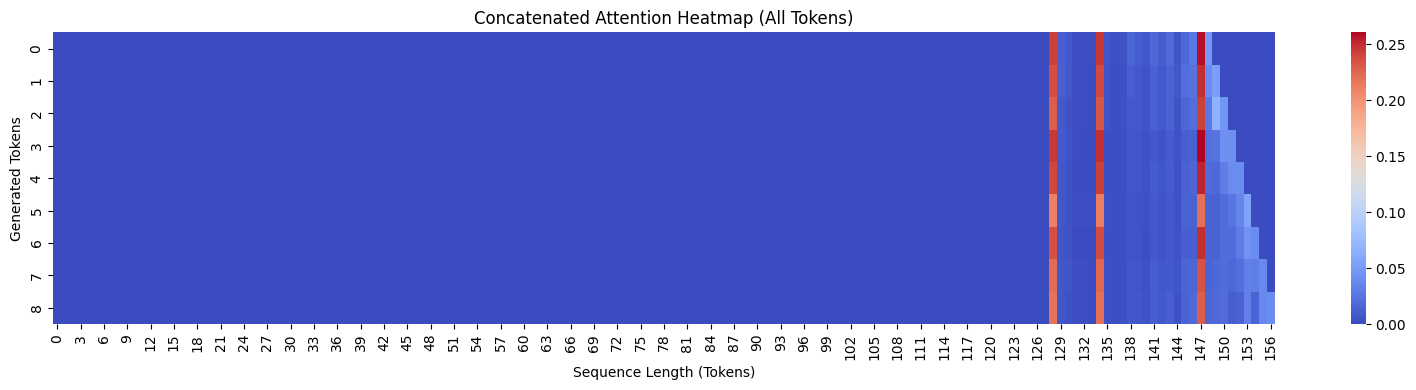

In [60]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def pad_and_concat_attentions(attention_tuple, max_seq_len):
    """
    Pad attention maps with zeros and concatenate them.
    
    Args:
    - attention_tuple: Tuple of attention tensors, where each tensor corresponds to one generated token's attention.
                       Shape: (generated_token_length, layers, 1, heads, 1, seq_len)
    - max_seq_len: The maximum sequence length to pad to.
    
    Returns:
    - concatenated_attentions: Tensor of concatenated attention maps (generated_token_length, seq_len)
    """
    padded_attentions = []
    
    for attn_tensor in attention_tuple:
        # print(attn_tensor.size())
        seq_len = attn_tensor[0].shape[-1]  # Current sequence length for this token
        padding_len = max_seq_len - seq_len
        
        attn_tensor = torch.cat(attn_tensor, 0).mean(0)
        # print(attn_tensor.size())
        # Average over layers and heads
        attn_tensor_avg = attn_tensor.mean(0).squeeze().squeeze().cpu() # Shape: (seq_len,)
        
        # Pad attention tensor with zeros to match max_seq_len
        if padding_len > 0:
            attn_tensor_avg = torch.cat([attn_tensor_avg, torch.zeros(padding_len)], dim=-1)
        
        padded_attentions.append(attn_tensor_avg)
    
    # Concatenate attentions across generated tokens
    concatenated_attentions = torch.stack(padded_attentions, dim=0)
    
    return concatenated_attentions

def draw_concatenated_attention_heatmap(concatenated_attentions):
    """
    Draw a heatmap of concatenated attention scores.
    
    Args:
    - concatenated_attentions: Tensor of concatenated attention scores (generated_token_length, seq_len).
    """
    
    plt.figure(figsize=(16, 4))
    
    # Convert tensor to numpy for plotting
    attention_data = concatenated_attentions.cpu().detach().numpy()
    
    sns.heatmap(attention_data, cmap='coolwarm', cbar=True)
    
    plt.title("Concatenated Attention Heatmap (All Tokens)")
    plt.xlabel("Sequence Length (Tokens)")
    plt.ylabel("Generated Tokens")
    plt.tight_layout()
    plt.show()

# Assume that the output attentions are of the shape (generated_token_length, layers, 1, heads, 1, seq_len)
generated_token_length = len(output['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in output['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(output['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)
